In [1]:
# Reading the dataset
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix

data_csv = "../breast-cancer-wisconsin.csv"
df = pd.read_csv(data_csv, names=['ID','Clump','U_Cell_size','U_Cell_shape','Marginal_Adhesion','SE_epitelial_cell_size','Bare_nuclei','bland_chromatin','Normal_Nucleoli','Mitoses','Class'])
print('Dataset shape: ', df.shape)
print(df.dtypes)
df.head()

Dataset shape:  (699, 11)
ID                         int64
Clump                      int64
U_Cell_size                int64
U_Cell_shape               int64
Marginal_Adhesion          int64
SE_epitelial_cell_size     int64
Bare_nuclei               object
bland_chromatin            int64
Normal_Nucleoli            int64
Mitoses                    int64
Class                      int64
dtype: object


,ID,Clump,U_Cell_size,U_Cell_shape,Marginal_Adhesion,SE_epitelial_cell_size,Bare_nuclei,bland_chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


#  Attribute                     Domain
-- -----------------------------------------
1. Sample code number            id number
2. Clump Thickness               1 - 10
3. Uniformity of Cell Size       1 - 10
4. Uniformity of Cell Shape      1 - 10
5. Marginal Adhesion             1 - 10
6. Single Epithelial Cell Size   1 - 10
7. Bare Nuclei                   1 - 10
8. Bland Chromatin               1 - 10
9. Normal Nucleoli               1 - 10
10. Mitoses                       1 - 10
11. Class:                        (0 for benign, 1 for malignant)

In [2]:
null_columns=df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head())
# Change bare nuclei values to numeric only and check the numbers of NAN
df['Bare_nuclei'] = pd.to_numeric(df['Bare_nuclei'], errors='coerce', downcast='integer')
print(df['Bare_nuclei'].isnull().values.sum())

# Drop the lines with null values
df = df.dropna()
print(df['Bare_nuclei'].isnull().values.sum())

# Removing ID column since it won't be considered to the training
df.pop('ID')

# So, the dataset removing null values and ID column has the size:
print('New dataset shape: ', df.shape)

Empty DataFrame
Columns: []
Index: []
16
0
New dataset shape:  (683, 10)


In [3]:
#Values distribution
for name, values in df.iteritems():
    print (name, '\nMin Value:  ', np.min(values), '\nMax Value: ', np.max(values), '\n\n')

Clump 
Min Value:   1 
Max Value:  10 


U_Cell_size 
Min Value:   1 
Max Value:  10 


U_Cell_shape 
Min Value:   1 
Max Value:  10 


Marginal_Adhesion 
Min Value:   1 
Max Value:  10 


SE_epitelial_cell_size 
Min Value:   1 
Max Value:  10 


Bare_nuclei 
Min Value:   1.0 
Max Value:  10.0 


bland_chromatin 
Min Value:   1 
Max Value:  10 


Normal_Nucleoli 
Min Value:   1 
Max Value:  10 


Mitoses 
Min Value:   1 
Max Value:  10 


Class 
Min Value:   2 
Max Value:  4 




In [4]:
# Changing Class label from 2 or 4 to 0 or 1
df.loc[:, 'Class'] = np.where(df['Class']==2, 0, 1)
print ('Class\nMin Value:  ', np.min(df['Class']), '\nMax Value: ', np.max(df['Class']), '\n\n')

Class
Min Value:   0 
Max Value:  1 




In [5]:
print(f"Total     = {len(df)} -> 100%")
print(f"Benign    = {len(df[df.Class == 0])} -> {len(df[df.Class == 0])/len(df) *100}%")
print(f"Malignant = {len(df[df.Class == 1])} -> {len(df[df.Class == 1])/len(df) *100}%")

Total     = 683 -> 100%
Benign    = 444 -> 65.00732064421669%
Malignant = 239 -> 34.99267935578331%


# Atributes correlation for benign and malignant samples

In [6]:
# Correlation benign samples
corr_mat_benign = df.loc[df.Class == 0].drop(['Class'], axis=1).corr()
corr_mat_benign

,Clump,U_Cell_size,U_Cell_shape,Marginal_Adhesion,SE_epitelial_cell_size,Bare_nuclei,bland_chromatin,Normal_Nucleoli,Mitoses
Clump,1.000000,0.275855,0.298429,0.255388,0.158063,0.115207,0.100785,0.205244,-0.039594
U_Cell_size,0.275855,1.000000,0.696421,0.281418,0.409948,0.461013,0.264898,0.487685,0.047185
U_Cell_shape,0.298429,0.696421,1.000000,0.239653,0.344502,0.358815,0.194651,0.390216,-0.000083
Marginal_Adhesion,0.255388,0.281418,0.239653,1.000000,0.292839,0.373200,0.116239,0.254664,0.062491
SE_epitelial_cell_size,0.158063,0.409948,0.344502,0.292839,1.000000,0.332888,0.152628,0.437988,-0.015829
Bare_nuclei,0.115207,0.461013,0.358815,0.373200,0.332888,1.000000,0.205968,0.308704,0.120092
bland_chromatin,0.100785,0.264898,0.194651,0.116239,0.152628,0.205968,1.000000,0.343546,-0.043424
Normal_Nucleoli,0.205244,0.487685,0.390216,0.254664,0.437988,0.308704,0.343546,1.000000,0.057632
Mitoses,-0.039594,0.047185,-0.000083,0.062491,-0.015829,0.120092,-0.043424,0.057632,1.000000


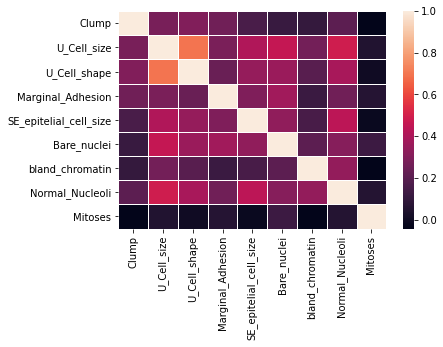

In [7]:
plt.figure()
ax = sns.heatmap(corr_mat_benign, linewidth=0.5)
plt.show()

In [8]:
corr_mat_malignant = df.loc[df.Class == 1].drop(['Class'], axis=1).corr()
corr_mat_malignant

,Clump,U_Cell_size,U_Cell_shape,Marginal_Adhesion,SE_epitelial_cell_size,Bare_nuclei,bland_chromatin,Normal_Nucleoli,Mitoses
Clump,1.000000,0.097438,0.112548,-0.144148,0.017152,-0.036078,-0.018025,-0.013174,0.118206
U_Cell_size,0.097438,1.000000,0.720782,0.320449,0.460828,-0.039891,0.388866,0.299189,0.241080
U_Cell_shape,0.112548,0.720782,1.000000,0.267325,0.383091,0.052947,0.338472,0.309652,0.209983
Marginal_Adhesion,-0.144148,0.320449,0.267325,1.000000,0.192775,0.193632,0.337764,0.184831,0.201249
SE_epitelial_cell_size,0.017152,0.460828,0.383091,0.192775,1.000000,-0.031428,0.216225,0.231148,0.333305
Bare_nuclei,-0.036078,-0.039891,0.052947,0.193632,-0.031428,1.000000,0.136894,-0.083194,-0.037522
bland_chromatin,-0.018025,0.388866,0.338472,0.337764,0.216225,0.136894,1.000000,0.253494,0.059304
Normal_Nucleoli,-0.013174,0.299189,0.309652,0.184831,0.231148,-0.083194,0.253494,1.000000,0.222353
Mitoses,0.118206,0.241080,0.209983,0.201249,0.333305,-0.037522,0.059304,0.222353,1.000000


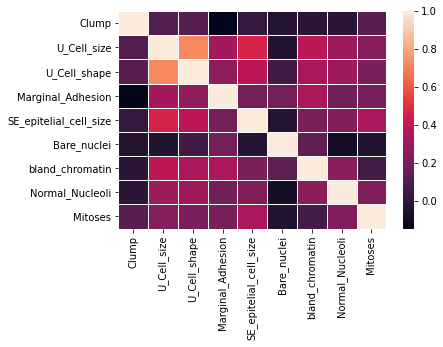

In [9]:
plt.figure()
ax = sns.heatmap(corr_mat_malignant, linewidth=0.5)
plt.show()

In [10]:
# Separate entries from outputs
dataset = df.to_numpy(dtype=np.int) # Converting from Pandas dataframe to Numpy
entries = dataset[:, 0:9]
outputs = dataset[:, 9]
print(entries.shape)
print(outputs.shape)


(683, 9)
(683,)


In [11]:
# Split dataset between train and test
seed = 10 # Set seed to get invariant results
test_size = 0.34
x_train, x_test, y_train, y_test = train_test_split(entries, outputs, test_size=test_size, random_state=seed)
print('Train dataset shape:\nEntries: ', x_train.shape, '\nOutput: ', y_train.shape, '\n\n')
print('Test dataset shape:\nEntries: ', x_test.shape, '\nOutput: ', y_test.shape)

Train dataset shape:
Entries:  (450, 9) 
Output:  (450,) 


Test dataset shape:
Entries:  (233, 9) 
Output:  (233,)


In [12]:
# Create 10-fold validation set for training
K = 10
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

# Decision Tree Classifier

In [13]:
# Decision Tree classifier
dt = tree.DecisionTreeClassifier(random_state=seed)

# Random Forest Classifier

In [14]:
# Random forest classifier
rf = RandomForestClassifier(n_estimators=20, random_state=seed)

# K-Nearest neighbor classifier

In [15]:
neigh = KNeighborsClassifier()

# Organizing classifiers

In [16]:
classifiers = [(dt, "Decision tree"), (rf, "Random forest"), (neigh, "K-Nearest neighbor")]

# Classifiers training

In [17]:
# Training classifiers using cross-validation
fold_number = 1
for train_indexes, valid_indexes in kf.split(x_train):
    print("Fold ", fold_number)
    for classifier, label in classifiers:
        classifier.fit(x_train[train_indexes], y_train[train_indexes])
        y_valid_pred = classifier.predict(x_train[valid_indexes])
        print("Classifier type: ",label, ", Validation Accuracy = ", accuracy_score(y_train[valid_indexes], y_valid_pred))
    print('\n')
    fold_number += 1


Fold  1
Classifier type:  Decision tree , Validation Accuracy =  0.9555555555555556
Classifier type:  Random forest , Validation Accuracy =  1.0
Classifier type:  K-Nearest neighbor , Validation Accuracy =  1.0


Fold  2
Classifier type:  Decision tree , Validation Accuracy =  0.9777777777777777
Classifier type:  Random forest , Validation Accuracy =  1.0
Classifier type:  K-Nearest neighbor , Validation Accuracy =  1.0


Fold  3
Classifier type:  Decision tree , Validation Accuracy =  0.9333333333333333
Classifier type:  Random forest , Validation Accuracy =  1.0
Classifier type:  K-Nearest neighbor , Validation Accuracy =  1.0


Fold  4
Classifier type:  Decision tree , Validation Accuracy =  0.9555555555555556
Classifier type:  Random forest , Validation Accuracy =  0.9777777777777777
Classifier type:  K-Nearest neighbor , Validation Accuracy =  1.0


Fold  5
Classifier type:  Decision tree , Validation Accuracy =  0.8888888888888888
Classifier type:  Random forest , Validation Accu

In [18]:
# Testing classifiers
for classifier, label in classifiers:
    y_test_estimative = classifier.predict(x_test)
    print("Classifier type: ", label, ", Test Accuracy = ", accuracy_score(y_test, y_test_estimative))

Classifier type:  Decision tree , Test Accuracy =  0.9399141630901288
Classifier type:  Random forest , Test Accuracy =  0.9699570815450643
Classifier type:  K-Nearest neighbor , Test Accuracy =  0.9828326180257511


# Confusion matrix calculation

In [19]:
confusion_matrixes = np.zeros((len(classifiers), 4))
for index, classifier_info in enumerate(classifiers):
    confusion_matrixes[index,:] = np.array([confusion_matrix(outputs, classifier_info[0].predict(entries)).ravel()])

<Figure size 432x288 with 0 Axes>

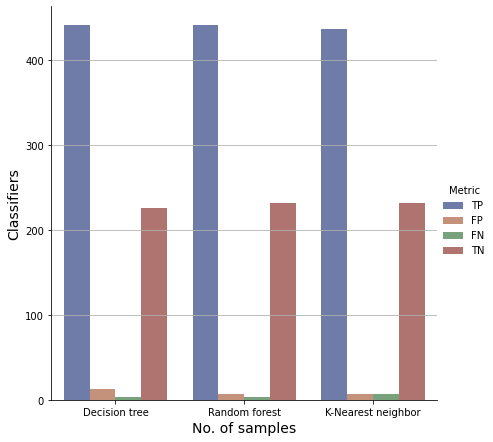

In [20]:
def plot_metrics(dataframe, metric_indexes, indexes_results, orientation, xlabel, ylabel):
    classifier_labels = ["Decision tree", "Random forest", "K-Nearest neighbor"]
    df_perf_results = pd.DataFrame(dataframe, columns=metric_indexes)
    df_perf_results.insert(0, 'classifier_type', classifier_labels, True)
    df_perf_results = pd.melt(df_perf_results, id_vars=['classifier_type'], value_vars=indexes_results, var_name='Metric')
    
    # Plot confusion matrixes for each classifier
    plt.figure()
    if orientation=="h":
        x = "value"
        y = "classifier_type"
        gridon = "x"
    else:
        y = "value"
        x = "classifier_type"
        gridon = "y"
    x = "value" if orientation=="h" else "classifier_type"
    y = "classifier_type" if orientation=="h" else "value"
    sns.catplot(data=df_perf_results, kind="bar", orient=orientation, x=x, y=y, hue="Metric", ci="sd", palette="dark", alpha=.6, height=6)
    plt.ylabel(xlabel, fontsize=14)
    plt.xlabel(ylabel, fontsize=14)
    plt.grid(axis=gridon)
    plt.show()

# Generate dataset to plot using seaborn package
indexes = ["TP", "FN", "FP", "TN"]
indexes_result1 = ["TP", "FP", "FN", "TN"]

plot_metrics(confusion_matrixes, indexes, indexes_result1, "v", "Classifiers", "No. of samples")

In [21]:
df_confusion_matrixes = pd.DataFrame(confusion_matrixes, columns=indexes, index=[label for _, label in classifiers])
df_confusion_matrixes.T

,Decision tree,Random forest,K-Nearest neighbor
TP,441.0,441.0,437.0
FN,3.0,3.0,7.0
FP,13.0,7.0,7.0
TN,226.0,232.0,232.0


# Calculates the performance metrics

In [22]:
def perf_metrics(confusion_values):
    # [0] = TP, [1] = FN , [2] = FP, [3] = TN
    # 4.1 accuracy
    accuracy = (confusion_values[0] + confusion_values[3]) / (np.sum(confusion_values))
    # 4.2 precision
    precision = confusion_values[0] / (confusion_values[0] + confusion_values[2])
    # 4.3 specificity
    specificity = confusion_values[3] / (confusion_values[3] + confusion_values[2])
    # 4.4 TP rate
    tp_rate = confusion_values[0] / (confusion_values[0] + confusion_values[1])
    # 4.5 FP rate
    fp_rate = confusion_values[2] / (confusion_values[2] + confusion_values[3])
    # 4.6 NPV
    npv = confusion_values[3] / (confusion_values[3] + confusion_values[1])
    # 4.7 Rate of Misclassification
    misclassification_rate = (confusion_values[2] + confusion_values[1]) / (np.sum(confusion_values))
    # 4.8 F1 Score
    f1_score = (precision * tp_rate) / (precision + tp_rate)

    return np.array([accuracy, precision, specificity, tp_rate, fp_rate, npv, misclassification_rate, f1_score])

perf_results = np.zeros((confusion_matrixes.shape[0], 8))
for i in np.arange(confusion_matrixes.shape[0]):
    perf_results[i,:] = perf_metrics(confusion_matrixes[i,:])

<Figure size 432x288 with 0 Axes>

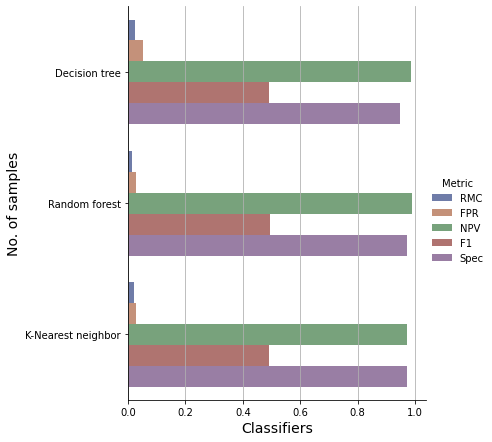

In [23]:
metric_indexes = ["CA", "Pre", "Spec", "Rec", "FPR", "NPV", "RMC", "F1"] # that stands for Classification accuracy, Precision, Specificity, Recall/TP rate, 
# False positive rate, negative predictive value, misclassification rate and F1, respectively.
indexes_result2 = ["RMC", "FPR", "NPV", "F1", "Spec"]

plot_metrics(perf_results, metric_indexes, indexes_result2, "h", "No. of samples", "Classifiers")

In [24]:
df_perf_results = pd.DataFrame(perf_results, columns=metric_indexes, index=[label for _, label in classifiers])
df_perf_results[indexes_result2].T

,Decision tree,Random forest,K-Nearest neighbor
RMC,0.023426,0.014641,0.020498
FPR,0.054393,0.029289,0.029289
NPV,0.986900,0.987234,0.970711
F1,0.491091,0.494395,0.492117
Spec,0.945607,0.970711,0.970711


<Figure size 432x288 with 0 Axes>

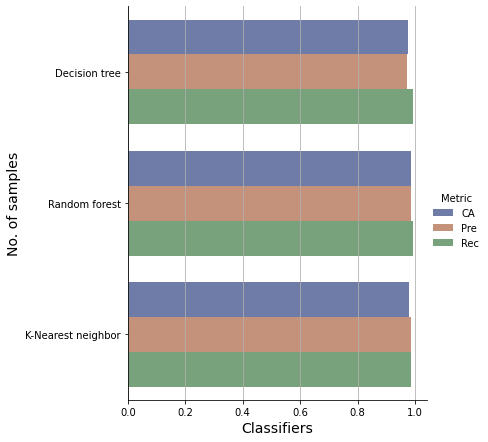

In [25]:
indexes_result3 = ["CA", "Pre", "Rec"]
plot_metrics(perf_results, metric_indexes, indexes_result3, "h", "No. of samples", "Classifiers")

In [26]:
df_perf_results = pd.DataFrame(perf_results, columns=metric_indexes, index=[label for _, label in classifiers])
df_perf_results[indexes_result3].T

,Decision tree,Random forest,K-Nearest neighbor
CA,0.976574,0.985359,0.979502
Pre,0.971366,0.984375,0.984234
Rec,0.993243,0.993243,0.984234


# (Todo Issue #7) Create ROC Curves

In [27]:
# Code to create ROC curve

# Paper negative points  (Let's make a list to use after)
- Does not mention the null values present at `Bare_nuclei` atribute
- Does not treat the proportion of benign and malign samples at training and test dataset
- We assume that `ID` column is not used to the training, but paper seems to consider it
- Normalization of entry values could improve the performance for some methods as NN
- Use a repeated K-fold cross validation could improve the performance
- Use grid-search to tune decision tree parameters could be implemented
- Does not specify any of the Decision tree parameters used (or they just use the default implementation without set any parameters)
- Calculates the decision matrix over the entire dataset
- Authors didn't remove NaN values before calculate the correlation
- Authors used the wrong labels at confusion matrixes of fig. 15, the right sequence is TN, FP, FN and TP.
- Authors plotted 2 times the F1 at both figure 16 and 17, and forgot to plot precision, and also plot AUC